In [1]:
import numpy as np
import os
import math
import matplotlib.pyplot as plt
%matplotlib inline

# Notes
1. Neural networks are just mathematical expressions.
2. Backpropagation is essentially applying the chain rule of calculus from the resulting value of an expression to get the derivative of the result w.r.t each of the variables in the expression.
3. In a NN, the expression is a function that takes the input data and weights of the neural network, and gives the prediction in terms of the loss function. We then do backpropagation (partial derivative of each of the weights of the NN w.r.t to the loss function) to get the gradient change direction and magnitude of the loss function as each weight variable changes. Using this information, we minimize the loss.
4. Backpropagation is general. We use it in a NN to get the gradients.
5. In a big neural network, all the weights are represented as tensors/arrays, but the math is the same. Because they are in these arrays, we can apply backpropagation to each of those values by taking advantage of the parallelism provided by GPUs.


In [2]:
def f(x):
    return 3*x**2 - 2*x - 1

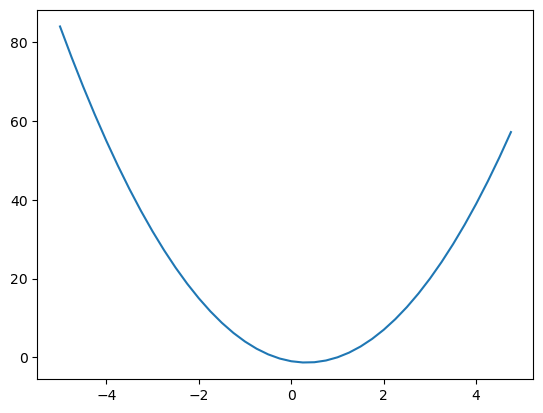

In [3]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs,ys)

In [4]:
# Derivative of f(x)
h = 0.001
x=3
dh = (f(x+h)-f(x))/h
dh

16.00300000000132

In [5]:
# Another f(x)
def f(a,b,c):
    return a*b+c


In [6]:
h = 0.00001
a = 2
b = -3
c = 10

y = f(a,b,c)
print("y: ", y)

#dy/da
dya = (f(a+h,b,c) - f(a,b,c))/h
print("dya: ", dya)

#dy/db
dyb = (f(a,b+h,c) - f(a,b,c))/h
print("dyb: ", dyb)


y:  4
dya:  -3.000000000064062
dyb:  2.0000000000131024


## For Neural networks, the expressions are massive. So we need a data structure to store those expressions and evaluate their derivates

In [7]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = _children
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data}, label={self.label})"
        
    def __add__(self, other):
        return Value(self.data + other.data, (self, other), '+')
    
    def __sub__(self, other):
        return Value(self.data - other.data, (self, other), '-')
    
    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), '*')

    def __div__(self, other):
        return Value(self.data / other.data, (self, other), '/')
    
    def __pow__(self, other):
        return Value(self.data ** other.data, (self, other), '**')
    

In [8]:
# Representing same above expression in the Value DS
a = Value(2, label='a')
b = Value(-3, label='b')
c = Value(10, label='c')

e = a*b; e.label='e'
y = e + c # Equivalent to a.__mul__(b).__add__(c)
y.label = 'y'
y, y._prev, y._op, y._prev[0]._prev, y._prev[0]._op

(Value(data=4, label=y),
 (Value(data=-6, label=e), Value(data=10, label=c)),
 '+',
 (Value(data=2, label=a), Value(data=-3, label=b)),
 '*')

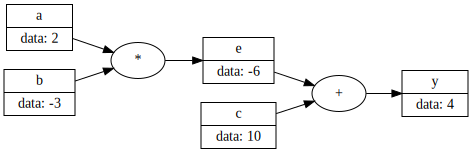

In [167]:
# Representing this expression as a graph

from graphviz import Digraph

def build(vertex, nodes, edges):
    if vertex not in nodes:
        nodes.add(vertex)
        for child in vertex._prev:
            edges.add((child, vertex))
            build(child, nodes, edges)


def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    build(root, nodes, edges)
    
    return nodes, edges
    

def draw_graph(root):
    graph = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    
    for node in nodes:
        uid = str(id(node))
        
        if hasattr(node, "grad"):
            graph.node(name=uid, label = f"{node.label} | data: {node.data} | grad: {node.grad}", shape='record')
        else:
            graph.node(name=uid, label = f"{node.label} | data: {node.data}", shape='record')
            
        if node._op:
            graph.node(name = uid + node._op, label = node._op)
            graph.edge(uid+node._op, uid)
        
    for node1, node2 in edges:
        graph.edge(str(id(node1)), str(id(node2)) + node2._op)
        
    return graph

        
draw_graph(y)

In [12]:
# Representing another expression in the Value DS
a = Value(2, label='a')
b = Value(-3, label='b')
c = Value(10, label='c')

e = a*b; e.label='e'
d = e + c; d.label = 'd'
f = Value(-2, label='f')
L = f*d; L.label='L'
L

Value(data=-8, label=L)

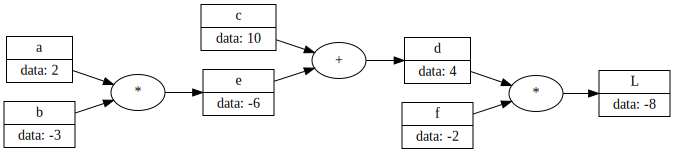

In [13]:
draw_graph(L)

## Now we need to calculate the derivative of L w.r.t each node for every node
### Eg dL/df, dL/de etc.

These nodes will eventually represent the weights of the neural network. So by doing backpropagation we know how the change in each of these weights is affecting the loss function. We can use this information to minimize the loss.
So essentially we need d(output)/d(weights) for all weights
We usually dont take derivative of the input because inputs are usually fixed and weights are trained

In [41]:
np.isscalar(f)

False

In [30]:
# Rewriting Value with gradient calculation
import numpy as np
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = _children
        self.grad = 0.0
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data}, label={self.label})"
        
    def __add__(self, other):
        if np.isscalar(other):
            return Value(self.data + other, (self, other), '+')
        else:
            return Value(self.data + other.data, (self, other), '+')
    
    def __sub__(self, other):
        return Value(self.data - other.data, (self, other), '-')
    
    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), '*')

    def __truediv__(self, other):
        if np.isscalar(other):
            return Value(self.data / other, (self, other), '/')
        else:
            return Value(self.data / other.data, (self, other), '/')
    
    def __pow__(self, other):
        return Value(self.data ** other.data, (self, other), '**')

    def tanh(self):
        n = self.data
        tanh_value = (math.exp(2*n)-1)/(math.exp(2*n)+1)
        return Value(tanh_value, (self,), 'tanh')
    

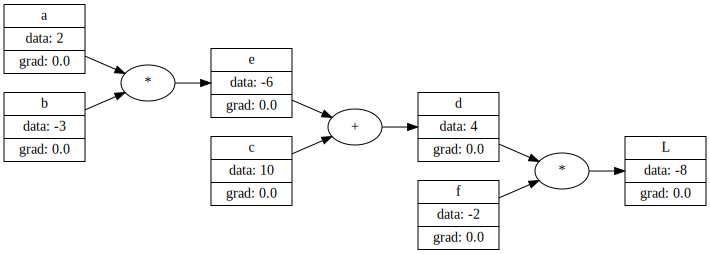

In [26]:
# Representing another expression in the Value DS
a = Value(2, label='a')
b = Value(-3, label='b')
c = Value(10, label='c')

e = a*b; e.label='e'
d = e + c; d.label = 'd'
f = Value(-2, label='f')
L = f*d; L.label='L'
draw_graph(L)

In [22]:
# Numerical gradient calculationg of each variable w.r.t L
h=0.00001

a = Value(2, label='a')
b = Value(-3, label='b')
c = Value(10, label='c')

e = a*b; e.label='e'
d = e + c; d.label = 'd'
f = Value(-2, label='f')
L1 = f*d; L.label='L1'

a = Value(2, label='a')
a = a + h 
b = Value(-3, label='b')
c = Value(10, label='c')
# c = c+h
e = a*b; e.label='e'
# e=e+h
d = e + c; d.label = 'd'
f = Value(-2, label='f')

L2 = f*d; L.label='L2'

(L2-L1)/h

Value(data=6.000000000128124, label=)

In [27]:
# Manually filling gradients by evaluating chain rule
L.grad = 1 # dL/dL
f.grad = 4 # dL/df = d(f*d)/df = d
d.grad = -2 # dL/dd = d(f*d)/dd = f
c.grad = -2 # dL/dc = (dL/dd)*(dd/dc) = -2 * d(e+c)/dc = -2 * 1 = -2
e.grad = -2 # dL/de = (dL/dd)*(dd/de) = -2 * d(e+c)/de = -2 * 1 = -2
b.grad = -4 # dL/db = (dL/de)*(de/db) = -2 * d(a*b)/db = -2 * a = -2 * 2 = -4
a.grad = 6 # dL/da = (dL/de)*(de/da) = -2 * d(a*b)/da = -2 * b = -2 * -3 = 6

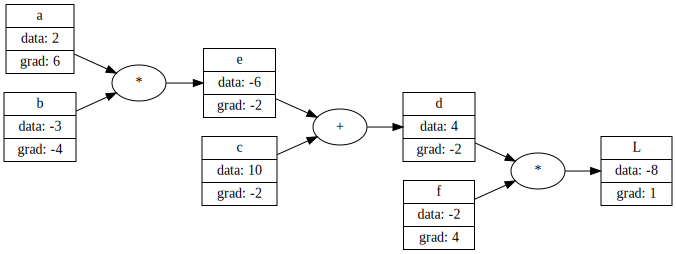

In [28]:
draw_graph(L)

## Backpropagation
### Essentially chain rule of calculus applied recursively through the computational graph from output to input (backwards)

### Loss function is reduced by changing the values along the gradients

In [93]:
# Loss updated by updating the values along the gradients
# Nudging inputs in the direction of the gradient to incrase the value of L
# We expect a less negative L value
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a*b
d = e + c
L = f*d

L.data

-7.286496

### Trying out manual backpropagation on a neuron

In [49]:
# Inputs x1 and x2
x1 = Value(2, label="x1")
x2 = Value(1, label="x2")
# two weights for each input
w1 = Value(-3, label="w1")
w2 = Value(0, label="w2")
# bias of the neuron
b = Value(8, label="b")

# Applying sum of inputs with weights
x1w1 = x1*w1
x1w1.label="x1w1"
x2w2 = x2*w2
x2w2.label="x2w2"
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = "x1w1+x2w2"
neuron1 = x1w1x2w2 + b
neuron1.label = "neuron1"
output = neuron1.tanh()
output.label = "output"


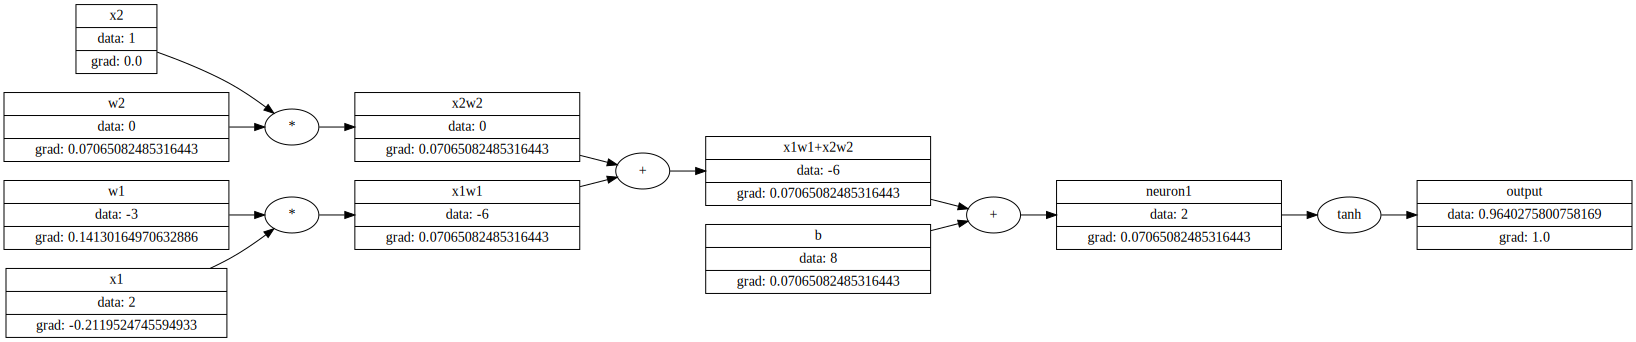

In [51]:
draw_graph(output)


In [50]:
# Filling gradients manually
output.grad = 1.0   #do/do=1
# output = tanh(neuron)
# d(output)/d(neuron) = 1 - output^2
neuron1.grad = 1 - output.data**2
b.grad = neuron1.grad # Plus sign local gradient is just 1. Hence d(output)/db = d(output)/d(neuron)*d(neuron)/db = d(output)/d(neuron)
x1w1x2w2.grad = neuron1.grad # Plus sign simple transfers the same gradient
x2w2.grad = x1w1x2w2.grad
x1w1.grad = x1w1x2w2.grad

x2.grad = w2.data*x2w2.grad # Multiply sign => f(x)=xy. Meaning f'(x)=y. So local gradient is essentially the other variable of the multiplication. That is multiplied with the incoming gradient
w2.grad = x2.data*x2w2.grad

x1.grad = w1.data*x1w1.grad
w1.grad = x1.data*x1w1.grad

Now implementing the gradient calculation using backpropagation in the Value object

In [117]:
# Rewriting Value with gradient calculation
import numpy as np
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = _children
        self.grad = 0.0
        self._backward = lambda: None
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data}, label={self.label})"
        
    def __add__(self, other):
        if np.isscalar(other):
            other = Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad  # Local gradient is 1 for addition, which is multiplied by the incoming gradient from the output
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out

    def __sub__(self, other:Value):
        return self + (-1*other)
    
    def __rmul__(self, other):
        return self*other

    def __mul__(self, other:Value):
        if np.isscalar(other):
            other = Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data*out.grad # Local derivative of multiplication is just the variable which is being multiplied to.
            other.grad += self.data*out.grad # Local derivative then multiplied with the incoming gradient from the output
        out._backward = _backward

        return out
    def __truediv__(self, other):
        if np.isscalar(other):
            other = Value(other)
        return self*other**-1
    
    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data**other, (self,), f'**{other}')
        def _backward():
            self.grad = (other*self.data**(other-1))*out.grad   # Local derivative of power function chained with output grad
        out._backward = _backward
        return out
    def exp(self):
        n = self.data
        exp_value = math.exp(n)
        out = Value(exp_value, (self, ), 'exp')

        def __backward():
            self.grad = out.data*out.grad   # Local gradient of exponentiation is itself
        out._backward = __backward

        return out

    def tanh(self):
        n = self.data
        tanh_value = (math.exp(2*n)-1)/(math.exp(2*n)+1)
        out = Value(tanh_value, (self,), 'tanh')

        def _backward():
            self.grad += (1 - out.data**2)*out.grad
        out._backward = _backward

        return out

    def backward(self):
        topo = []
        def build_topo(v, visited):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child, visited)
                topo.append(v)
        build_topo(self, set())
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


In [115]:
a = Value(2)
b= 
2*a,a*2, a.exp()

(Value(data=4, label=),
 Value(data=4, label=),
 Value(data=7.38905609893065, label=))

In [97]:
# Inputs x1 and x2
x1 = Value(2, label="x1")
x2 = Value(1, label="x2")
# two weights for each input
w1 = Value(-3, label="w1")
w2 = Value(0, label="w2")
# bias of the neuron
b = Value(8, label="b")

# Applying sum of inputs with weights
x1w1 = x1*w1
x1w1.label="x1w1"
x2w2 = x2*w2
x2w2.label="x2w2"
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = "x1w1+x2w2"
neuron1 = x1w1x2w2 + b
neuron1.label = "neuron1"
output = neuron1.tanh()
output.label = "output"


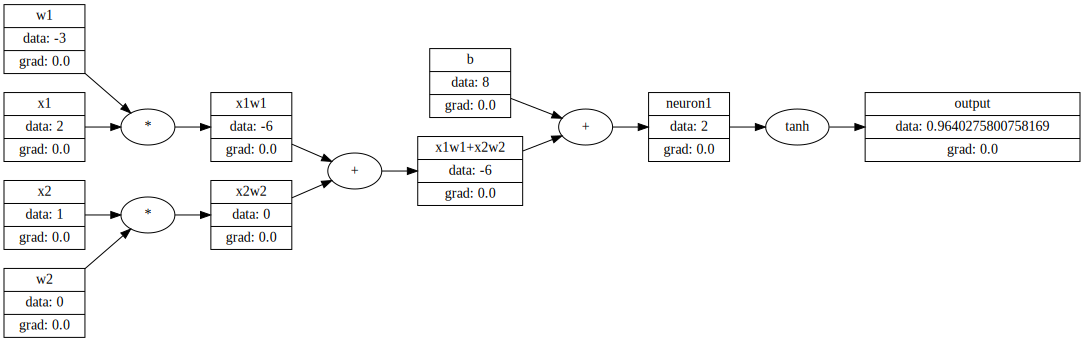

In [98]:
draw_graph(output)

In [63]:
output.grad = 1.0
output._backward()

In [64]:
neuron1._backward()

In [66]:
b._backward()

In [68]:
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

In [91]:
# Topological sort
topo = []
def build_topo(v, visited):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child, visited)
        topo.append(v)
build_topo(output, set())
topo

[Value(data=2, label=x1),
 Value(data=-3, label=w1),
 Value(data=-6, label=x1w1),
 Value(data=1, label=x2),
 Value(data=0, label=w2),
 Value(data=0, label=x2w2),
 Value(data=-6, label=x1w1+x2w2),
 Value(data=8, label=b),
 Value(data=2, label=neuron1),
 Value(data=0.9640275800758169, label=output)]

In [94]:
# Topological sort for the computational graph
# Applying backward in the reversed order to make sure the further layer backward is called before
output.grad=1
topo = []
build_topo(output, set())
for node in reversed(topo):
    node._backward()

Value(data=0.9640275800758169, label=output)
Value(data=2, label=neuron1)
Value(data=8, label=b)
Value(data=-6, label=x1w1+x2w2)
Value(data=0, label=x2w2)
Value(data=0, label=w2)
Value(data=1, label=x2)
Value(data=-6, label=x1w1)
Value(data=-3, label=w1)
Value(data=2, label=x1)


In [99]:
# Doing backprop
output.backward()

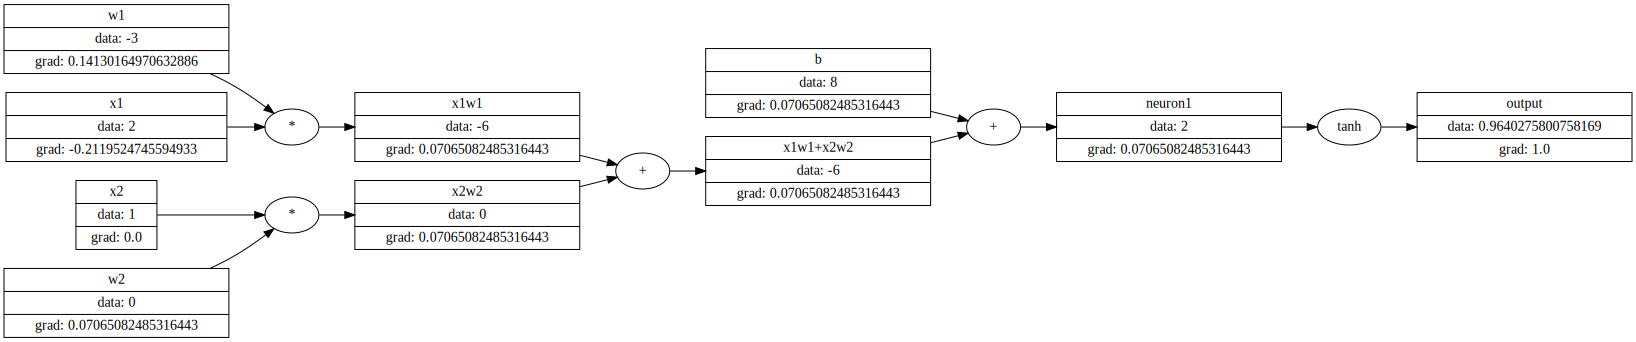

In [100]:
draw_graph(output)

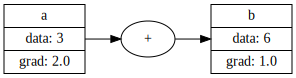

In [111]:
# Case where same variable is used twice
a = Value(3, label='a')
b= a + a
b.label = "b"
b.backward()
draw_graph(b)

In [122]:
# Inputs x1 and x2
x1 = Value(2, label="x1")
x2 = Value(1, label="x2")
# two weights for each input
w1 = Value(-3, label="w1")
w2 = Value(0, label="w2")
# bias of the neuron
b = Value(8, label="b")

# Applying sum of inputs with weights
x1w1 = x1*w1
x1w1.label="x1w1"
x2w2 = x2*w2
x2w2.label="x2w2"
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = "x1w1+x2w2"
neuron1 = x1w1x2w2 + b
neuron1.label = "neuron1"
# Replacing tanh with the composite operations
e = (2*neuron1).exp()
output = (e-1)/(e+1)
output.label = "output"
output.backward()


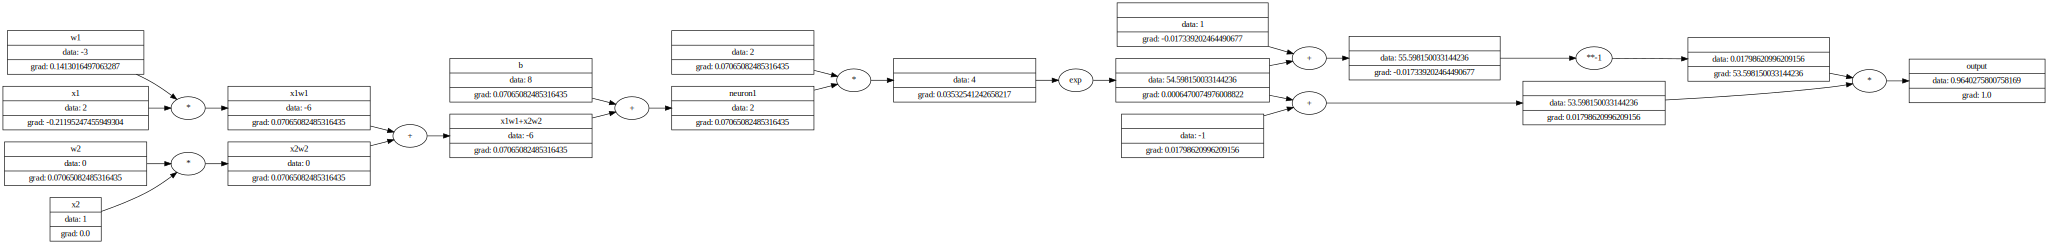

In [123]:
draw_graph(output)

In [124]:
import torch

ModuleNotFoundError: No module named 'torch'

In [180]:
import random
class Neuron:

    def __init__(self, nin) -> None:
        self.w = [Value(random.uniform(-1,1)) for i in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        activation = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        output = activation.tanh()

        return output

class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for i in range(nout)]

    def __call__(self, x):
        output = [n(x) for n in self.neurons]

        return output[0] if len(output)==1 else output

class MLP:
    def __init__(self , nin, nouts):
        sizes = [nin] + nouts
        self.layers = [Layer(sizes[i], sizes[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [144]:
x=[3,1,5]
n = Neuron(2)
print(n(x))
layer = Layer(2,3)
layer(x)

Value(data=0.12723607706778714, label=)


[Value(data=0.9985539440699399, label=),
 Value(data=-0.991490522984193, label=),
 Value(data=0.9369397547381831, label=)]

In [181]:
x=[3,1,5]
mlp = MLP(3,[4,4,1])
mlp(x)

Value(data=-0.6275882694798218, label=)

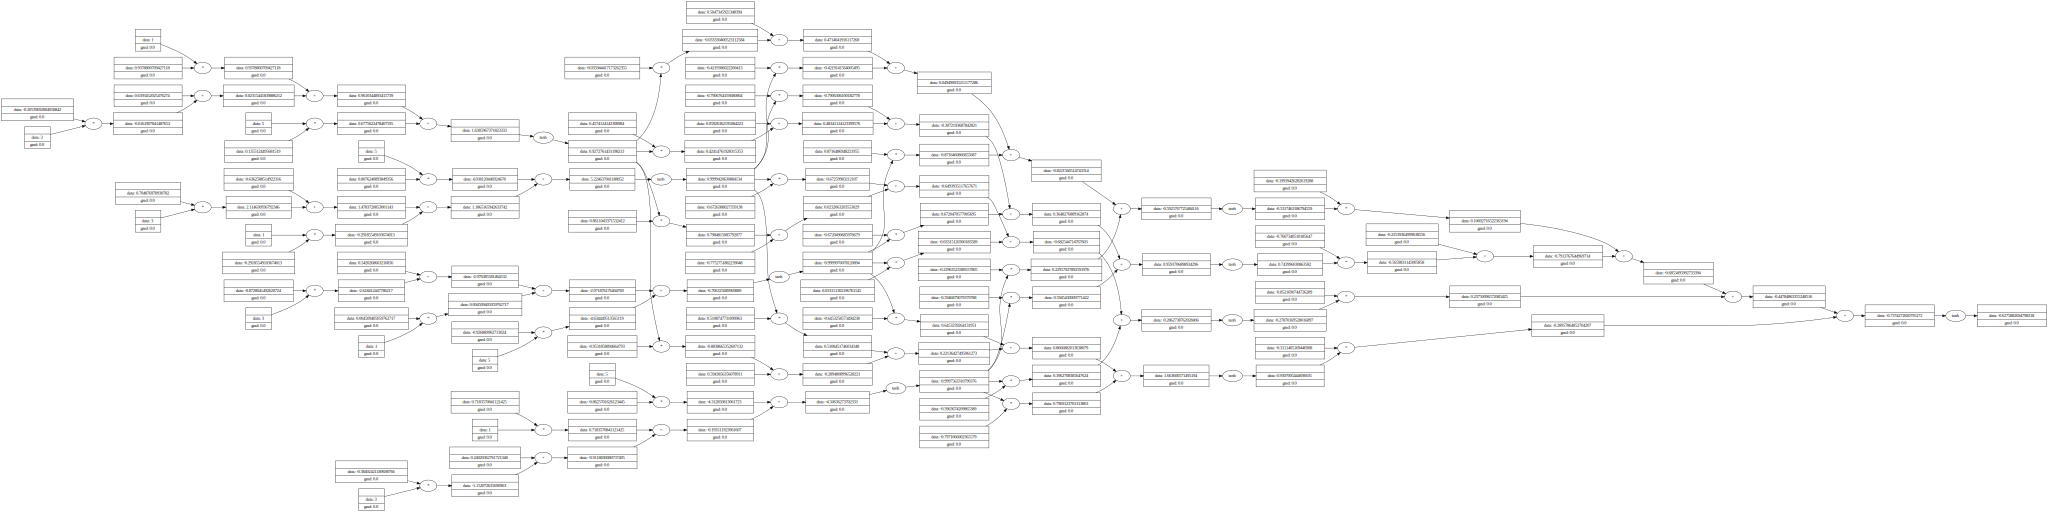

In [182]:
draw_graph(mlp(x))

In [183]:
xs = [
    [2,3,-1],
    [3,-1,0.5],
    [0.5,1,1],
    [1,1,-1]
]
ys = [1,-1,-1,1]
ypred = [mlp(x) for x in xs]
ypred

[Value(data=-0.5382777481402464, label=),
 Value(data=0.19210818332780985, label=),
 Value(data=-0.604385720000319, label=),
 Value(data=-0.32119202755499593, label=)]

In [184]:
for ygt, yout in zip(ys, ypred):
    print((yout-ygt)**2)


Value(data=2.3662984304234276, label=)
Value(data=1.4211219207571308, label=)
Value(data=0.156510658539666, label=)
Value(data=1.7455483736748814, label=)
